In [1]:
import os
from datetime import datetime, timedelta
import pandas as pd
import quandl as qd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns

In [2]:
key = os.environ.get('Quandl_API_Key')
qd.ApiConfig.api_key = key

In [3]:
# "RATEINF/INFLATION_USA" "MULTPL/SP500_PE_RATIO_MONTH" "MULTPL/SP500_EARNINGS_MONTH"

In [4]:
today = datetime.today().date()

# get the actual day number
today_day_num = today.strftime("%d")

In [5]:
start_date = "1965-01-01"

end_date = today - timedelta(days=int(today_day_num) - 1) #Establish the end date as the first date of the current month

inflation_data = qd.get("RATEINF/INFLATION_USA", start_date = start_date, end_date = end_date)

pe_data = qd.get("MULTPL/SP500_PE_RATIO_MONTH", start_date = start_date, end_date = end_date)

In [6]:
df = pd.merge_asof(left=inflation_data, right=pe_data, right_index=True,left_index=True,direction='nearest') #Merge to the closest date since the days do not line up perfectly
df = df.rename(columns={'Value_x':'Inflation',
                        'Value_y':'S&P500_PE'})
df

,Inflation,S&P500_PE
Date,,
1965-01-31,0.971,18.71
1965-02-28,0.971,18.55
1965-03-31,1.294,18.59
1965-04-30,1.618,18.65
1965-05-31,1.618,17.57
...,...,...
2022-08-31,8.263,19.98
2022-09-30,8.202,18.12
2022-10-31,7.745,20.14


In [7]:
df.describe()

,Inflation,S&P500_PE
count,696.000000,696.000000
mean,3.983807,19.658420
std,2.867817,12.045199
min,-2.097000,6.790000
25%,2.107000,14.115000
50%,3.187500,17.940000
75%,4.979000,22.500000
max,14.756000,123.730000


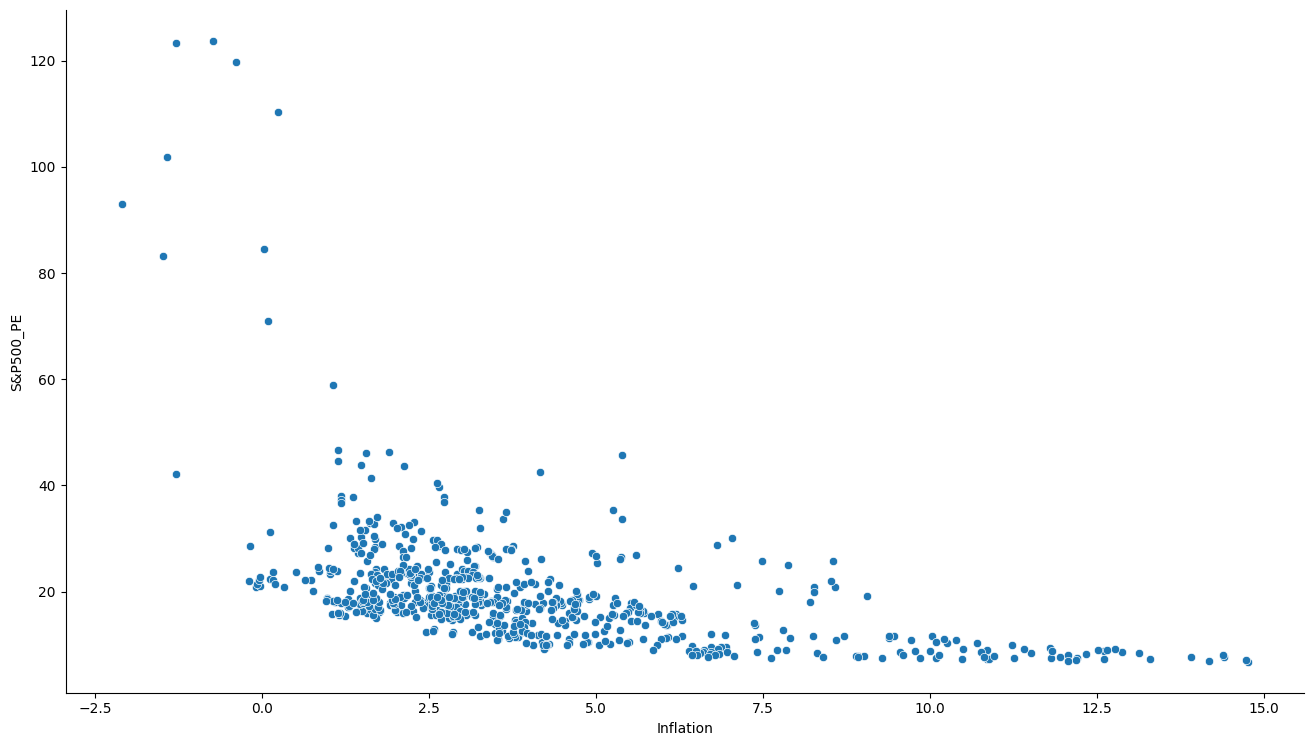

In [8]:
g = sns.relplot(x='Inflation', y='S&P500_PE', data=df)
g.fig.set_size_inches(15,8)

In [9]:
#Remove outliers in S&P 500

#upper_limit = df['S&P500_PE'].mean()+2*df['S&P500_PE'].std()
#lower_limit = df['S&P500_PE'].mean()-2*df['S&P500_PE'].std()

upper_limit = df['S&P500_PE'].quantile(0.95)

df = df[(df['S&P500_PE'] < upper_limit)]

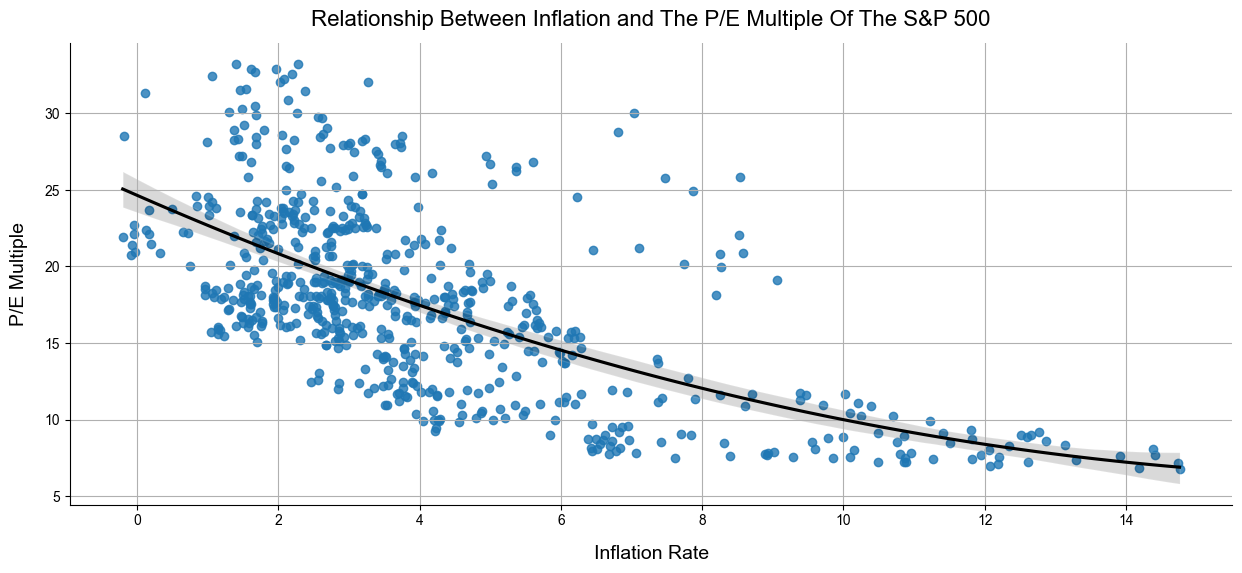

In [10]:
fig = plt.figure(figsize=(15, 6))
sns.regplot(x='Inflation', y='S&P500_PE', data=df, order = 2, line_kws={"color":"black"})
sns.set(style="ticks")
sns.despine()
plt.xlabel("Inflation Rate", fontsize= 14, labelpad =12)
plt.ylabel("P/E Multiple", fontsize= 14, labelpad =12)
plt.title("Relationship Between Inflation and The P/E Multiple Of The S&P 500", fontsize=16, pad= 12)
plt.grid();

In [11]:
X = df['Inflation']
y = df['S&P500_PE']

## Statsmodel Method

https://ostwalprasad.github.io/machine-learning/Polynomial-Regression-using-statsmodel.html

In [12]:
from sklearn.preprocessing import PolynomialFeatures
sm_poly = PolynomialFeatures(degree=2)
sm_poly_features = sm_poly.fit_transform(X.values.reshape(-1,1))

model = sm.OLS(y, sm_poly_features).fit()
ypred = model.predict(sm_poly_features) 

In [13]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              S&P500_PE   R-squared:                       0.410
Model:                            OLS   Adj. R-squared:                  0.408
Method:                 Least Squares   F-statistic:                     228.4
Date:                Mon, 13 Feb 2023   Prob (F-statistic):           4.77e-76
Time:                        16:02:21   Log-Likelihood:                -1946.1
No. Observations:                 661   AIC:                             3898.
Df Residuals:                     658   BIC:                             3912.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         24.6511      0.535     46.061      0.000      23.600      25.702
x1            -2.0157      0.215     -9.390      0.000      -2.437      -1.594
x2             0.0551      0.016      3.351      0.001       0.023       0.087
==============================================================================
Omnibus:                       69.085   Durbin-Watson:                   0.061
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               88.348
Skew:                           0.865   Prob(JB):                     6.54e-20
Kurtosis:                       3.466   Cond. No.                         144.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [14]:
print(f"The r-squared score of the model is {round(model.rsquared,2)}")

The r-squared score of the model is 0.41


In [15]:
model.params

const    24.651108
x1       -2.015719
x2        0.055091
dtype: float64

In [31]:
user_input = 6.45
test = sm_poly.fit_transform(np.array(user_input).reshape(-1,1))
new_result = round(model.predict(test)[0],2)
new_result

13.94

In [32]:
prediction_intervals = model.get_prediction(test)
intervals = prediction_intervals.summary_frame(alpha=0.05)
intervals

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,13.941624,0.310832,13.331282,14.551965,4.874814,23.008434


In [36]:
mean_pred = prediction_intervals.predicted_mean
mean_pred[0]

13.94162378377453

In [24]:
lower, upper = prediction_intervals.conf_int(alpha=0.05).T

print(lower[0])
print(upper[0])

5.236365701605324
9.221199717619887


In [25]:
conf = model.conf_int(alpha=0.05)
conf

,0,1
const,23.600231,25.701986
x1,-2.437255,-1.594183
x2,0.022810,0.087371


In [19]:
print(f"The point estimate of the user input is: {round(intervals['mean'][0],2)}")
print(f"The lower confidence interval is: {round(intervals['mean_ci_lower'][0],2)}")
print(f"The upper confidence interval is: {round(intervals['mean_ci_upper'][0],2)}")

The point estimate of the user input is: 7.23
The lower confidence interval is: 5.24
The upper confidence interval is: 9.22


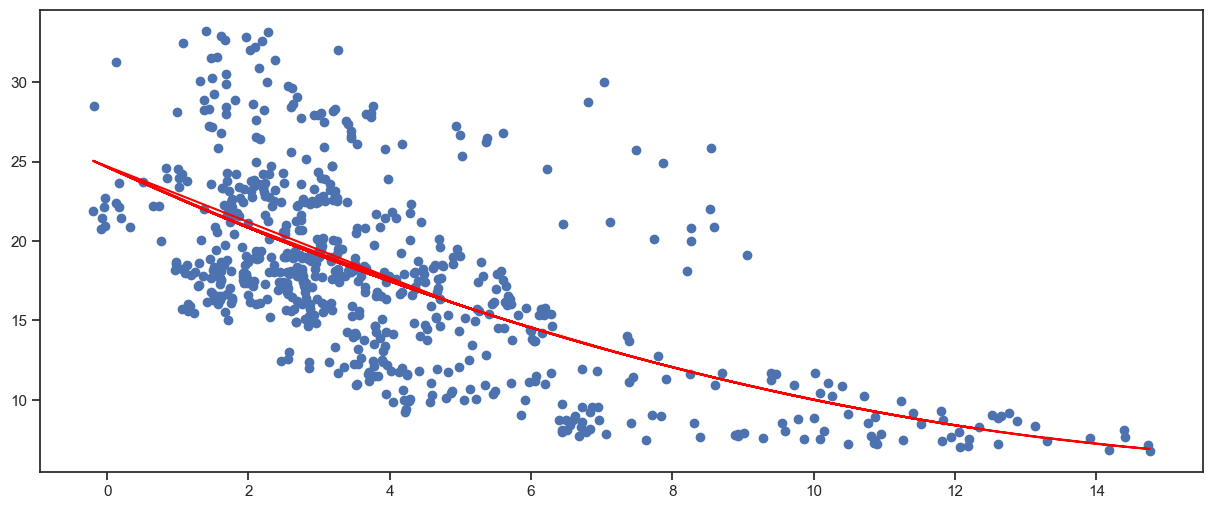

In [20]:
plt.figure(figsize=(15, 6))
plt.scatter(X, y)
plt.plot(X, ypred, c="red")
plt.show()